# Variational Autoencoder for Handwritten Digital (Trial 2)

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

## The MNIST dataset

### Get the data
MNIST dataset is provided by Keras directly. The following codes show how to load it.

In [34]:
# the data, shuffled and split between train and test sets
(X_train_pre, y_train_pre), (X_test_pre, y_test_pre) = mnist.load_data()

In [35]:
img_rows, img_cols = 28, 28
X_train = X_train_pre.reshape(X_train_pre.shape[0], img_rows*img_cols)
X_test = X_test_pre.reshape(X_test_pre.shape[0], img_rows*img_cols)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.
X_test /= 255.

print('training data shape:', X_train.shape)
print('{} train samples, {} test samples'.format(X_train.shape[0], X_test.shape[0]))

training data shape: (60000, 784)
60000 train samples, 10000 test samples


## The model

### Build the model

In [36]:
# network parameters
intermediate_dim = 512
latent_dim = 2

# build encoder model
inputs = layers.Input(shape=(img_rows * img_cols,), name='encoder_input')

# build a hidden layer
h = layers.Dense(512, activation='relu')(inputs)

# generate latent vector Q(z|X)
mu = layers.Dense(2, name='mu')(h)
log_sigma = layers.Dense(2, name='sigma')(h)

In [37]:
# use reparameterization trick to push the sampling out as input
# instead of sampling from Q(z|X)
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
       sample eps = N(0,I), then z = mean + sqrt(var)*eps
    Arguments:
        args:       mean and log of variance of Q(z|X)
    Returns:
        z (tensor): sampled latent vector
    """
    mean, log_var = args
    batch = K.shape(mean)[0]
    dim = K.int_shape(mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return mean + K.exp(0.5 * log_var) * epsilon


z = layers.Lambda(sampling, output_shape=(2,), name='z')([mu, log_sigma])

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 784)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_17 (Dense)          │ (None, 512)            │        401,920 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mu (Dense)                │ (None, 2)              │          1,026 │ dense_17[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sigma (Dense)             │ (None, 2)              │          1,026 │ dense_17[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 2)              │              0 │ mu[0][0], sigma[0][0]  │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 403,972 (1.54 MB)

 Trainable params: 403,972 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

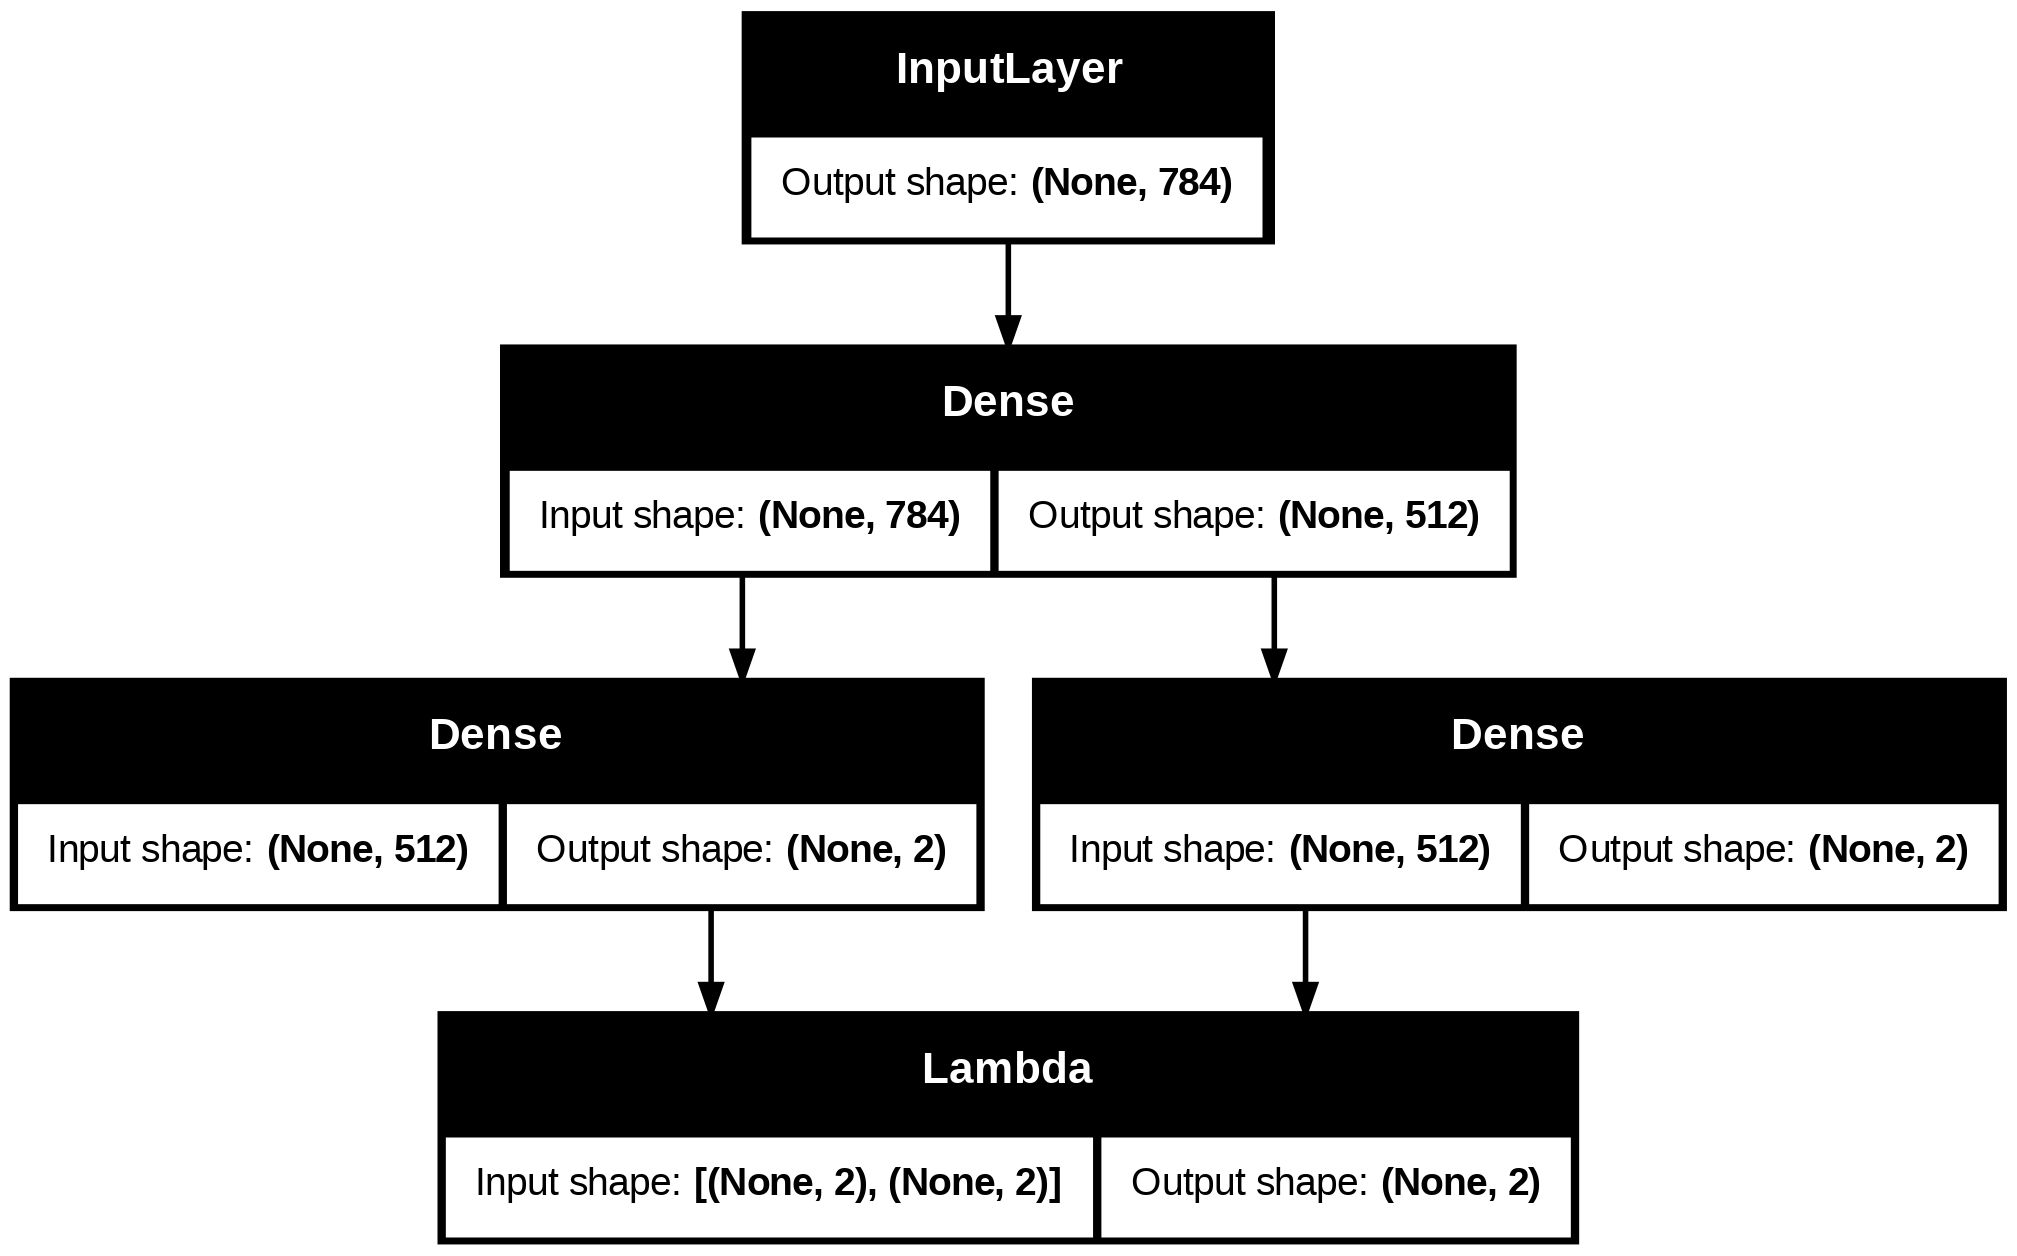

In [38]:
# instantiate encoder model
encoder = Model(inputs, [mu,log_sigma,z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_encoder.png', show_shapes=True)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)              │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 512)                 │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 784)                 │         402,192 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 403,728 (1.54 MB)

 Trainable params: 403,728 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

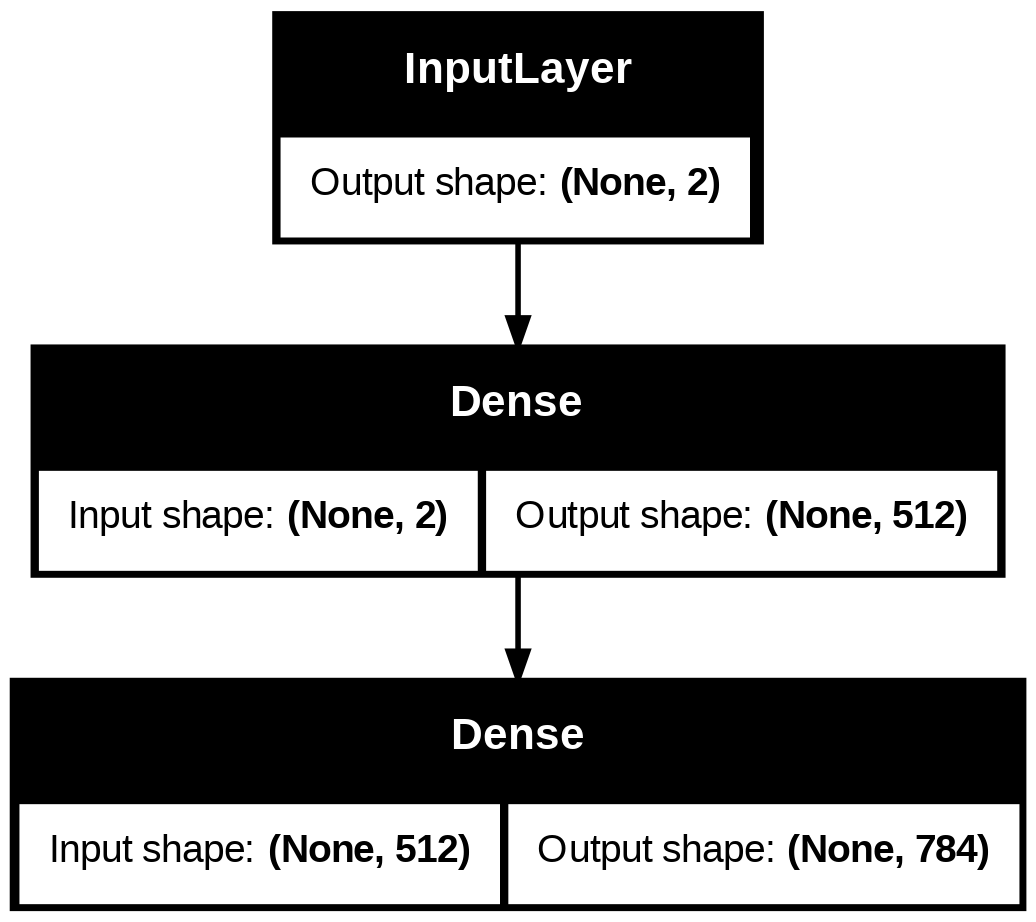

In [39]:
# build decoder model
latent_inputs = layers.Input(shape=(2,), name='z_sampling')
h2 = layers.Dense(512, activation='relu')(latent_inputs)
outputs = layers.Dense(img_rows*img_cols, activation='sigmoid')(h2)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_decoder.png', show_shapes=True)

In [40]:
# Create a Custom Layer to Compute and Add the Loss
class VAELossLayer(layers.Layer):
    def __init__(self, img_rows, img_cols, **kwargs):
        self.img_rows = img_rows
        self.img_cols = img_cols
        super(VAELossLayer, self).__init__(**kwargs)

    def call(self, inputs):
        # Unpack inputs: encoder inputs, decoder outputs, mu, log_sigma.
        encoder_inputs, decoder_outputs, mu, log_sigma = inputs

        # Compute reconstruction loss: flatten inputs and outputs, then use binary crossentropy.
        reconstruction_loss = binary_crossentropy(K.flatten(encoder_inputs),
                                                  K.flatten(decoder_outputs))
        reconstruction_loss *= self.img_rows * self.img_cols  # scale by image size

        # Compute KL divergence loss:
        kl_loss = -0.5 * K.sum(1 + log_sigma - K.square(mu) - K.exp(log_sigma), axis=-1)

        # Total loss for each sample:
        total_loss = reconstruction_loss + kl_loss

        # Add the mean loss over the batch to the layer.
        self.add_loss(K.mean(total_loss))

        # Pass through the decoder outputs (this layer doesn’t modify them)
        return decoder_outputs

In [41]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])  # Connect decoder to encoder output

# Wrap the Loss Computation in the Custom Layer
# The loss will be computed and added to the model when this layer is called.
loss_layer = VAELossLayer(img_rows, img_cols, name='vae_loss')([inputs, outputs, mu, log_sigma])

# Build the VAE Model with the loss layer included
vae = Model(inputs, [outputs, loss_layer], name='vae_model')  # Include loss layer in outputs

from tensorflow.keras.optimizers import RMSprop
vae.compile(optimizer=RMSprop(0.003))

In [ ]:
BATCH = 200
EPOCHS = 40

vae.fit(X_train,
        epochs=EPOCHS,
        batch_size=BATCH,
        validation_data=(X_test, None))

Epoch 1/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - loss: 213.9963 - val_loss: 170.2107
Epoch 2/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - loss: 168.7330 - val_loss: 165.6319
Epoch 3/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 164.8455 - val_loss: 164.4355
Epoch 4/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 162.9188 - val_loss: 163.2788
Epoch 5/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 161.0817 - val_loss: 159.5930
Epoch 6/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - loss: 159.1966 - val_loss: 158.7579
Epoch 7/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - loss: 158.2575 - val_loss: 158.3619
Epoch 8/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - loss: 157.4692 - val_loss: 157.0120
Epoch 9/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - loss: 157.1025 - val_loss: 157.8055
Epoch 10/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 156.5300 - val_loss: 156.8217
Epoch 11/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - loss: 155.7611 - val_l

In [ ]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector

    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data

    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size, verbose=0)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

In [ ]:
models = (encoder, decoder)
data = (X_test, y_test_pre)
plot_results(models, data, batch_size=BATCH, model_name="vae_mnist")

### Build the model 2
contains one more dense layer

In [ ]:
# network parameters
intermediate_dim1 = 1024
intermediate_dim2 = 128
latent_dim = 10

# build encoder model
inputs = layers.Input(shape=(img_rows * img_cols,), name='encoder_input')

# generate latent vector Q(z|X)
x = layers.Dense(intermediate_dim1, activation='relu')(inputs)
h = layers.Dense(intermediate_dim2, activation='relu')(x)
mu = layers.Dense(latent_dim, name='mu')(h)
log_sigma = layers.Dense(latent_dim, name='sigma')(h)

In [ ]:
# use reparameterization trick to push the sampling out as input
# instead of sampling from Q(z|X)
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
       sample eps = N(0,I), then z = mean + sqrt(var)*eps
    Arguments:
        args:       mean and log of variance of Q(z|X)
    Returns:
        z (tensor): sampled latent vector
    """
    mean, log_var = args
    batch = K.shape(mean)[0]
    dim = K.int_shape(mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return mean + K.exp(0.5 * log_var) * epsilon


z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([mu, log_sigma])

In [ ]:
# instantiate encoder model
encoder = Model(inputs, [mu,log_sigma,z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_encoder.png', show_shapes=True)

In [ ]:
# build decoder model
latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim2, activation='relu')(latent_inputs)
x = layers.Dense(intermediate_dim1, activation='relu')(x)
outputs = layers.Dense(img_rows*img_cols, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
# plot_model(decoder, to_file='vae_decoder.png', show_shapes=True)

In [ ]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])  # Connect decoder to encoder output

# Wrap the Loss Computation in the Custom Layer
# The loss will be computed and added to the model when this layer is called.
loss_layer = VAELossLayer(img_rows, img_cols, name='vae_loss')([inputs, outputs, mu, log_sigma])

# Build the VAE Model with the loss layer included
vae = Model(inputs, [outputs, loss_layer], name='vae_model')  # Include loss layer in outputs

vae.compile(optimizer=RMSprop(0.003))

In [ ]:
BATCH = 200
EPOCHS = 40

vae.fit(X_train,
        epochs=EPOCHS,
        batch_size=BATCH,
        validation_data=(X_test, None))

Epoch 1/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 26s 80ms/step - loss: 213.6599 - val_loss: 138.3288
Epoch 2/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - loss: 136.2407 - val_loss: 125.3866
Epoch 3/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - loss: 125.6521 - val_loss: 119.6455
Epoch 4/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - loss: 119.8772 - val_loss: 117.8643
Epoch 5/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 43s 86ms/step - loss: 117.0214 - val_loss: 116.1545
Epoch 6/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 39s 81ms/step - loss: 115.0047 - val_loss: 112.5662
Epoch 7/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 40s 79ms/step - loss: 113.5141 - val_loss: 111.8585
Epoch 8/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - loss: 112.5952 - val_loss: 113.6285
Epoch 9/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - loss: 111.9590 - val_loss: 110.9438
Epoch 10/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - loss: 111.1526 - val_loss: 112.8098
Epoch 11/40
300/300 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - loss: 110.6368 - val_l

In [ ]:
n = 10
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
z_samples = np.random.randn(n*n, latent_dim)
x_decoded = decoder.predict(z_samples)

for i in range(n):
    for j in range(n):
        digit = x_decoded[i*n+j, :].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.title("generated data from vae decoder")
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [ ]:
# compared to the original dataset
n = 10
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

for i in range(n):
    for j in range(n):
        digit = X_test[i*n+j, :].reshape([digit_size, digit_size])
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.title("original data from test set")
plt.imshow(figure, cmap='Greys_r')
plt.show()